In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import multiprocessing as mp
import pickle 
import warnings 
warnings.filterwarnings('ignore')

from imports import*
from utils import *
from logistic_regression import *
from rnn import *

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [1]:
# num of agent
num_of_agents = 40

# num of block
num_of_block = 3

# num of trials 
num_of_trials = 200

# for cross valdation 
array = np.arange(num_of_block)
cv = [np.roll(array,i) for i in range(num_of_block)]
cv = np.array(cv)

models = {
    
    'habit':[  configuration_parameters_habit,
               habit_sim,
               habit_fit,
               habit_predict]
}


def bce(y_hat,y_true):
    eps = 1e-7
    return -np.sum( y_true*np.log(y_hat+eps) + (1-y_true)*np.log(1-y_hat+eps) )

NameError: name 'np' is not defined

In [ ]:
# upload data
all_data = [] 
for sim in range(1,num_of_block+1):
    data_per_block = []
    for agent in range(1,num_of_agents+1):
        data_per_block.append((pd.read_csv(f'../data/exploration/exploration_agent_{agent}_sim_{sim}.csv')))
    all_data.append(data_per_block)
    
block_0 = all_data[0]
block_1 = all_data[1]
block_2 = all_data[2]

all_blocks = [block_0,block_1,block_2]

In [ ]:
data_results = {
    
   'agent': [],
   'model': [],
   'train_block': [],
    
   'train_nll_hybrid' : [],
   'val_nll_hybrid' : [],
   'test_nll_hybrid': [], 

   'train_nll_habit' : [], 
   'val_nll_habit' : [],
   'test_nll_habit': [], 

   'train_nll_kdh' : [], 
   'val_nll_kdh' : [],
   'test_nll_kdh': [], 
    
}

all_best_param = []


K = 5
N = num_of_agents
data_results['agent'].append(np.tile(np.arange(0,N),len(cv)))
data_results['train_block'].append(np.repeat(cv[:,0],N))
#data_results['model'].append(np.tile(np.repeat(['hybrid','habit','kdh'],num_of_agents),num_of_block))


for train, val, test in cv:
    print(f'*** train {train} | val {val} | test {test} ***')
    
    # fit k times
    fit_res = []
    for _ in range(K):
        pool = mp.Pool(processes=mp.cpu_count())
        fit = pool.map(models[m][2], all_blocks[train])
        pool.close()
        fit_res.append(fit)
        
    # best train/validation nll    
    all_nll_train = np.zeros(shape=(K,N))
    all_nll_val = np.zeros(shape=(K,N))
    all_nll_test = np.zeros(shape=(K,N))
    best_parameters = [] 
    for k in range(K):
        for n in range(N):
            _ , y_hat, _ = models[m][3](all_blocks[train][n], fit_res[k][n].x)
            nLL = bce(1-y_hat, all_blocks[train][n]['action_stage_1'].values)
            all_nll_train[k,n] =  nLL
            
            _ , y_hat, _ = models[m][3](all_blocks[val][n], fit_res[k][n].x)
            nLL = bce(1-y_hat, all_blocks[val][n]['action_stage_1'].values)
            all_nll_val[k,n] = nLL
            
            _ , y_hat, _ = models[m][3](all_blocks[test][n], fit_res[k][n].x)
            nLL = bce(1-y_hat, all_blocks[test][n]['action_stage_1'].values)
            all_nll_test[k,n] = nLL
            
    best_train = all_nll_train.min(axis=0)
    best_val = all_nll_val.min(axis=0)
    indx = np.argmin(all_nll_val,axis=0)
    best_test = np.array([all_nll_test[indx[n],n] for n in range(N)])
    best_param = np.array([fit_res[indx[n]][n].x for n in range(N)])

    all_best_param.append(best_param)
    data_results[f'train_nll_{m}'].append(best_train)
    data_results[f'val_nll_{m}'].append(best_val)
    data_results[f'test_nll_{m}'].append(best_test)
        

for k in data_results:
    data_results[k] = np.concatenate(data_results[k])
df_the = pd.DataFrame(data_results)


  0%|          | 0/1 [00:00<?, ?it/s]

*** Fit with habit ***
*** train 0 | val 1 | test 2 ***
*** train 2 | val 0 | test 1 ***
*** train 1 | val 2 | test 0 ***


100%|██████████| 1/1 [01:44<00:00, 104.90s/it]


ValueError: need at least one array to concatenate

In [ ]:
K = 5
N = num_of_agents

data_results_lr = {
        
   'train_nll_lr' : [],
   'val_nll_lr' : [],
   'test_nll_lr': [], 
    
}

for train, val, test in cv:
    print(f'*** train {train} | val {val} | test {test} ***')
    
    all_nll_train = np.zeros(shape=(K,N))
    all_nll_val = np.zeros(shape=(K,N))
    all_nll_test = np.zeros(shape=(K,N))
    
    fit_res = []    
    for k in range(K):
        cur_res = []
        for n in range(N):
            X, y = preprocess_logistic_regression(all_blocks[train][n],lag=k+1)
            clf, inter, coef = fit_logistic_regression(X,y)
            cur_res.append(clf)
        fit_res.append(cur_res)
            
    # best train/validation nll    
    for k in range(K):
        for n in range(N):
            clf = fit_res[k][n]
            
            # train
            X, y = preprocess_logistic_regression(all_blocks[train][n],lag=k+1)
            if clf == None:
                nLL = -np.log(.5)*num_of_trials
            else:
                y_hat = clf.predict_proba(X)[:,0]
                nLL = bce(1-y_hat, all_blocks[train][n]['action_stage_1'].values)
            
            all_nll_train[k,n] = nLL
            
            # validation
            X, y = preprocess_logistic_regression(all_blocks[val][n],lag=k+1)
            if clf == None:
                nLL = -np.log(.5)*num_of_trials
            else:
                y_hat = clf.predict_proba(X)[:,0]
                nLL = bce(1-y_hat, all_blocks[val][n]['action_stage_1'].values)
            
            all_nll_val[k,n] = nLL

            X, y = preprocess_logistic_regression(all_blocks[test][n],lag=k+1)            
            if clf == None:
                nLL = -np.log(.5)*num_of_trials
            else:
                y_hat = clf.predict_proba(X)[:,0]
                nLL = bce(1-y_hat, all_blocks[test][n]['action_stage_1'].values)
                
            all_nll_test[k,n] = nLL
            
    best_train = all_nll_train.min(axis=0)
    best_val = all_nll_val.min(axis=0)
    indx = np.argmin(all_nll_val,axis=0)
    best_test = np.array([all_nll_test[indx[n],n] for n in range(N)])
    
    data_results_lr[f'train_nll_lr'].append(best_train)
    data_results_lr[f'val_nll_lr'].append(best_val)
    data_results_lr[f'test_nll_lr'].append(best_test)
    
for k in data_results_lr:
    data_results_lr[k] = np.concatenate(data_results_lr[k])
df_lr = pd.DataFrame(data_results_lr)


df = pd.concat([df_the,df_lr],axis=1)
df.to_csv('../results/theory_lr.csv')
            

In [ ]:
def calculate_weight_changes_rank(net, network_states_per_epoch, val_loss, window_size=5):
    """
    Calculate the rank of weight changes matrix around the optimal epoch.
    
    Args:
        net: The trained neural network
        network_states_per_epoch: List of network states from training
        val_loss: Validation loss array from training
        window_size: Number of epochs to consider before and after optimal epoch
        
    Returns:
        tuple: (weight_changes_rank, optimal_epoch_idx)
    """
    # Find optimal epoch based on validation loss
    optimal_epoch_idx = np.argmin(val_loss)
    
    # Calculate weight changes around optimal epoch
    weight_changes_matrix_list = []
    
    # Consider window_size epochs before and after the optimal epoch
    start_epoch = max(0, optimal_epoch_idx - window_size)
    end_epoch = min(len(network_states_per_epoch) - 1, optimal_epoch_idx + window_size)
    
    for t in range(start_epoch, end_epoch):
        # Create temporary networks for states at t and t+1
        network_at_t = GRU_NN(INPUT_SIZE, net.hidden_size, 1, OUTPUT_SIZE).to(device)
        network_at_t_plus_1 = GRU_NN(INPUT_SIZE, net.hidden_size, 1, OUTPUT_SIZE).to(device)
        
        # Load states
        network_at_t.load_state_dict(network_states_per_epoch[t])
        network_at_t_plus_1.load_state_dict(network_states_per_epoch[t + 1])
        
        # Compute weight changes between consecutive states
        weight_changes = compute_weight_changes_between_states(
            network_at_t, network_at_t_plus_1)
        weight_changes_matrix_list.append(weight_changes)
    
    # Combine all weight changes into single matrix
    complete_weight_changes_matrix = np.hstack(weight_changes_matrix_list)
    
    # Calculate rank of weight changes matrix
    weight_changes_rank = np.linalg.matrix_rank(complete_weight_changes_matrix)
    
    return weight_changes_rank, optimal_epoch_idx

In [ ]:
N = num_of_agents

INPUT_SIZE = 4 # 3 for the action (one-hot format) and 1 for the reward of the chosen action
OUTPUT_SIZE = 3 # probabilities of choosing each action in the next trial
LERANING_RATE = 0.001

hidden_size = 5
num_layers = 1
epochs = 1000

loss_train, loss_val, loss_test  = [], [], []
ll_train, ll_val, ll_test = [], [], []
ranks, optimal_epochs = [], []

for n in tqdm(range(N)):
    network_states_per_epoch = []
    for train, val, test in cv:

        train_data = behavior_dataset(all_blocks[train][n])
        val_data = behavior_dataset(all_blocks[val][n])
        test_data = behavior_dataset(all_blocks[test][n])

        train_loader = DataLoader(train_data,shuffle=False,batch_size=len(train_data))
        val_loader = DataLoader(val_data,shuffle=False,batch_size=len(val_data))
        test_loader = DataLoader(test_data,shuffle=False,batch_size=len(test_data))
        
        rnn = GRU_NN(INPUT_SIZE, hidden_size, num_layers, OUTPUT_SIZE)
        rnn, train_loss, train_ll, val_loss, val_ll, test_loss, test_ll, network_states_per_epoch = train_model(rnn,
                                                                                train_loader,
                                                                                val_loader,
                                                                                test_loader,
                                                                                epochs=epochs,
                                                                                lr=LERANING_RATE) 
        
        rank, optimal_epoch = calculate_weight_changes_rank(rnn, network_states_per_epoch, val_loss)
                                                                                                                                       
        loss_train.append(train_loss)
        loss_val.append(val_loss)
        loss_test.append(test_loss)
        
        ll_train.append(train_ll)
        ll_val.append(val_ll)
        ll_test.append(test_ll)

        ranks.append(rank)
        optimal_epochs.append(optimal_epoch)
        
    print('Done agent',n)
    
    
with open('../results/loss_train.pickle', 'wb') as handle:
    pickle.dump(loss_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../results/loss_val.pickle', 'wb') as handle:
    pickle.dump(loss_val, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../results/loss_test.pickle', 'wb') as handle:
    pickle.dump(loss_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../results/ll_train.pickle', 'wb') as handle:
    pickle.dump(ll_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../results/ll_val.pickle', 'wb') as handle:
    pickle.dump(ll_val, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../results/ll_test.pickle', 'wb') as handle:
    pickle.dump(ll_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../results/ranks.pickle', 'wb') as handle:
    pickle.dump(ranks, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../results/optimal_epochs.pickle', 'wb') as handle:
    pickle.dump(optimal_epochs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
        
        

  2%|▎         | 1/40 [03:21<2:10:56, 201.44s/it]

Done agent 0


  5%|▌         | 2/40 [06:40<2:06:43, 200.10s/it]

Done agent 1


  8%|▊         | 3/40 [09:57<2:02:26, 198.55s/it]

Done agent 2


 10%|█         | 4/40 [13:15<1:58:55, 198.22s/it]

Done agent 3


 12%|█▎        | 5/40 [16:29<1:54:45, 196.73s/it]

Done agent 4


 15%|█▌        | 6/40 [19:46<1:51:36, 196.96s/it]

Done agent 5


 18%|█▊        | 7/40 [23:08<1:49:15, 198.65s/it]

Done agent 6


 20%|██        | 8/40 [26:28<1:46:08, 199.00s/it]

Done agent 7


 22%|██▎       | 9/40 [29:45<1:42:28, 198.34s/it]

Done agent 8


 25%|██▌       | 10/40 [33:07<1:39:45, 199.52s/it]

Done agent 9


 28%|██▊       | 11/40 [36:30<1:36:53, 200.47s/it]

Done agent 10


 30%|███       | 12/40 [39:52<1:33:50, 201.08s/it]

Done agent 11


 32%|███▎      | 13/40 [43:08<1:29:44, 199.42s/it]

Done agent 12


 35%|███▌      | 14/40 [46:29<1:26:42, 200.09s/it]

Done agent 13


 38%|███▊      | 15/40 [49:53<1:23:46, 201.04s/it]

Done agent 14


 40%|████      | 16/40 [53:11<1:20:07, 200.33s/it]

Done agent 15


 42%|████▎     | 17/40 [56:29<1:16:32, 199.68s/it]

Done agent 16


 45%|████▌     | 18/40 [59:43<1:12:35, 197.97s/it]

Done agent 17


 48%|████▊     | 19/40 [1:03:02<1:09:23, 198.28s/it]

Done agent 18


 50%|█████     | 20/40 [1:06:21<1:06:08, 198.45s/it]

Done agent 19


 52%|█████▎    | 21/40 [1:09:40<1:02:54, 198.65s/it]

Done agent 20


 55%|█████▌    | 22/40 [1:12:58<59:31, 198.44s/it]  

Done agent 21


 57%|█████▊    | 23/40 [1:16:17<56:14, 198.49s/it]

Done agent 22


 60%|██████    | 24/40 [1:19:32<52:38, 197.43s/it]

Done agent 23


 62%|██████▎   | 25/40 [1:22:51<49:28, 197.89s/it]

Done agent 24


 65%|██████▌   | 26/40 [1:26:07<46:05, 197.50s/it]

Done agent 25


 68%|██████▊   | 27/40 [1:29:25<42:47, 197.53s/it]

Done agent 26


 70%|███████   | 28/40 [1:32:44<39:36, 198.03s/it]

Done agent 27


 72%|███████▎  | 29/40 [1:36:05<36:25, 198.72s/it]

Done agent 28


 75%|███████▌  | 30/40 [1:39:21<33:00, 198.08s/it]

Done agent 29


 78%|███████▊  | 31/40 [1:42:35<29:31, 196.84s/it]

Done agent 30


 80%|████████  | 32/40 [1:45:47<26:02, 195.30s/it]

Done agent 31


 82%|████████▎ | 33/40 [1:49:00<22:43, 194.73s/it]

Done agent 32


 85%|████████▌ | 34/40 [1:52:13<19:24, 194.08s/it]

Done agent 33


 88%|████████▊ | 35/40 [1:55:31<16:16, 195.21s/it]

Done agent 34


 90%|█████████ | 36/40 [1:58:45<13:00, 195.11s/it]

Done agent 35


 92%|█████████▎| 37/40 [2:02:04<09:48, 196.06s/it]

Done agent 36


 95%|█████████▌| 38/40 [2:05:21<06:32, 196.28s/it]

Done agent 37


 98%|█████████▊| 39/40 [2:08:46<03:19, 199.17s/it]

Done agent 38


100%|██████████| 40/40 [2:12:03<00:00, 198.08s/it]

Done agent 39


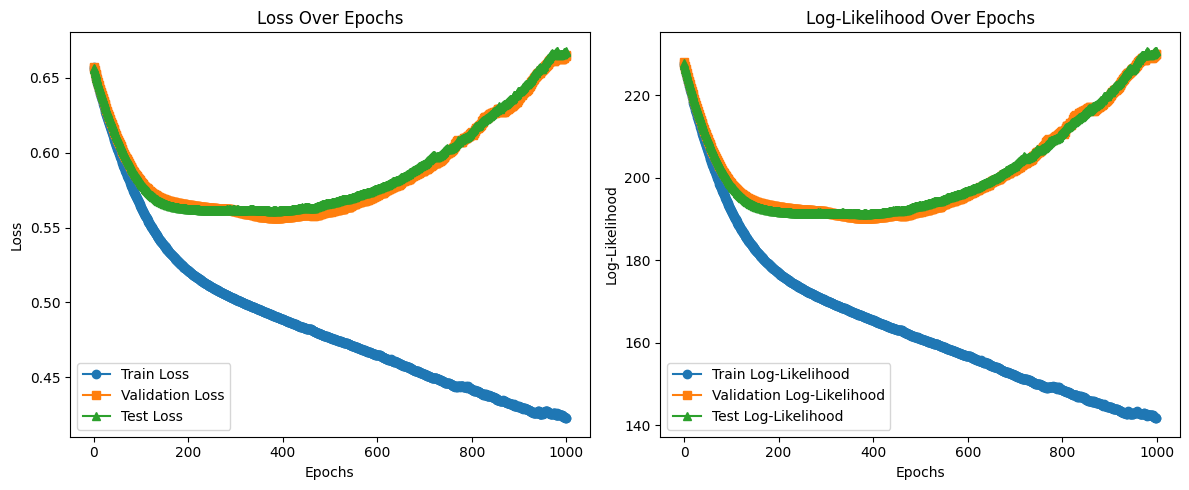

In [7]:
import matplotlib.pyplot as plt
import pickle

# Load the results from pickle files
file_paths = {
    "loss_train": "../results/loss_train.pickle",
    "loss_val": "../results/loss_val.pickle",
    "loss_test": "../results/loss_test.pickle",
    "ll_train": "../results/ll_train.pickle",
    "ll_val": "../results/ll_val.pickle",
    "ll_test": "../results/ll_test.pickle"
}

results = {}
for key, path in file_paths.items():
    with open(path, 'rb') as handle:
        results[key] = pickle.load(handle)

# Convert lists of lists to averaged lists per epoch
epochs = len(results["loss_train"][0])  # Assuming all have the same epoch length
avg_results = {key: [sum(epoch) / len(epoch) for epoch in zip(*values)] for key, values in results.items()}

# Plotting loss and log-likelihood
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
axes[0].plot(range(epochs), avg_results["loss_train"], label="Train Loss", marker="o")
axes[0].plot(range(epochs), avg_results["loss_val"], label="Validation Loss", marker="s")
axes[0].plot(range(epochs), avg_results["loss_test"], label="Test Loss", marker="^")
axes[0].set_title("Loss Over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Log-likelihood plot
axes[1].plot(range(epochs), avg_results["ll_train"], label="Train Log-Likelihood", marker="o")
axes[1].plot(range(epochs), avg_results["ll_val"], label="Validation Log-Likelihood", marker="s")
axes[1].plot(range(epochs), avg_results["ll_test"], label="Test Log-Likelihood", marker="^")
axes[1].set_title("Log-Likelihood Over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Log-Likelihood")
axes[1].legend()

plt.tight_layout()
plt.show()
